<a href="https://colab.research.google.com/github/AllanKamimura/Ocean_Data/blob/main/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

{"_links": {"_first": "https://api.planet.com/data/v1/searches/3ccdb66b4db7411db726c328e74b8e65/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9wcmV2IjogZmFsc2UsICJxdWVyeV9wYXJhbXMiOiB7fX0%3D", "_next": "https://api.planet.com/data/v1/searches/3ccdb66b4db7411db726c328e74b8e65/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6ICIyMDIxLTA5LTAxVDA0OjM4OjA5LjAwMDAwMFoiLCAic29ydF9sYXN0X2lkIjogIjIwMjEwODMxXzE4MDgxMV8zNF8yNDVjIiwgInNvcnRfcHJldiI6IGZhbHNlLCAicXVlcnlfcGFyYW1zIjoge319", "_self": "https://api.planet.com/data/v1/searches/3ccdb66b4db7411db726c328e74b8e65/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9wcmV2IjogZmFsc2UsICJxdWVyeV9wYXJhbXMiOiB7fX0%3D"}, "features": [{"_links": {"_self": "https://api

# Download clean data

In [ ]:
from google_drive_downloader import GoogleDriveDownloader

file_id = "1I3FZTRVU7iRTl7p1qHP7HIXmBo7fb_Oh"
GoogleDriveDownloader.download_file_from_google_drive(
    file_id = file_id,
    dest_path = "./train.zip",
    unzip = True
)

In [ ]:
import numpy as np
import pandas as pd

path_list = ["/content/1-5000.csv",
             "/content/5001-10000.csv",
             "/content/10001-15000.csv",
             "/content/15000-21mar.csv"]

for path in path_list[0:1]:
    df = pd.read_csv(path)
    cut_df = df[df["id"].isin((df["id"].value_counts() > 30)[(df["id"].value_counts() > 30) == True].index)][["id", "month", "lat", "lon"]]
    cut_df["month"] = cut_df["month"] / 12
    cut_df["lat"] = cut_df["lat"] / 90
    cut_df["lon"] = cut_df["lon"] / 360
    new_df = cut_df.copy()

for path in path_list[1:]:
    df = pd.read_csv(path)
    cut_df = df[df["id"].isin((df["id"].value_counts() > 30)[(df["id"].value_counts() > 30) == True].index)][["id", "month", "lat", "lon"]]
    cut_df["month"] = cut_df["month"] / 12
    cut_df["lat"] = cut_df["lat"] / 90
    cut_df["lon"] = cut_df["lon"] / 360
    new_df = pd.concat([new_df, cut_df.copy()], axis = 0)

new_df.info()

# Visual

In [ ]:
example_df = new_df[new_df.id.isin(new_df.id.unique()[:20])]

fig = px.line_geo(example_df, 
                  lat = example_df["lat"] * 90,
                  lon = example_df["lon"] * 360,
                  color="id", # "continent" is one of the columns of gapminder
                  #projection="orthographic"
                  )

fig.update_layout(
    title_text = 'Contour lines over globe<br>(Click and drag to rotate)',
    showlegend = False,
    height = 800, width = 1000,
    geo = dict(
        showland = True,
        showcountries = True,
        showocean = True,
        countrywidth = 0.5,
        landcolor = 'rgb(15, 128, 0)',
        lakecolor = 'rgb(13, 13, 115)',
        oceancolor = 'rgb(13, 13, 115)',
        projection = dict(
            type = 'orthographic',
            rotation = dict(
                lon = -100,
                lat = 40,
                roll = 0
            )
        ),
        lonaxis = dict(
            showgrid = True,
            gridcolor = 'rgb(102, 102, 102)',
            gridwidth = 0.5
        ),
        lataxis = dict(
            showgrid = True,
            gridcolor = 'rgb(102, 102, 102)',
            gridwidth = 0.5
        )
    )
)

fig.show()

# model train

In [ ]:
month_linha_sequence = []
lat_linha_sequence = []
lon_linha_sequence = []

for id in new_df["id"].unique():

    id_cut = new_df[new_df["id"] == id].values
    for i in range(0, 17):
        month_linha_sequence.append(id_cut[i:i+2,1])
        lat_linha_sequence.append(id_cut[i:i+2,2]) # coluna 0 é o index, 1 é o id
        lon_linha_sequence.append(id_cut[i:i+2,3])

In [ ]:
import tensorflow as tf

month_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(month_linha_sequence, maxlen = 2, padding = "pre", dtype='float32')
lat_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(lat_linha_sequence, maxlen = 2, padding = "pre", dtype='float32')
lon_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(lon_linha_sequence, maxlen = 2, padding = "pre", dtype='float32')

train_month_x, train_month_y = month_padded_sequences[:360000,1:], month_padded_sequences[:360000,0]
train_lat_x, train_lat_y = lat_padded_sequences[:360000,1:], lat_padded_sequences[:360000,0]
train_lon_x, train_lon_y = lon_padded_sequences[:360000,1:], lon_padded_sequences[:360000,0]

val_month_x, val_month_y = month_padded_sequences[360000:,1:], month_padded_sequences[360000:,0]
val_lat_x, val_lat_y = lat_padded_sequences[360000:,1:], lat_padded_sequences[360000:,0]
val_lon_x, val_lon_y = lon_padded_sequences[360000:,1:], lon_padded_sequences[360000:,0]

In [5]:
def my_model():
    lat = tf.keras.layers.Input(shape = [1], name = "latitude")
    lon = tf.keras.layers.Input(shape = [1], name = "longitude")
    month = tf.keras.layers.Input(shape = [1], name = "date")

    x = tf.keras.layers.Concatenate()([lat, lon, month])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units = 128, activation = "relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units = 128, activation = "relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.Dense(units = 64, activation = "relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units = 32, activation = "relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    y1 = tf.keras.layers.Dense(units = 1, activation = "tanh", name = "prev_lat")(x)
    y2 = tf.keras.layers.Dense(units = 1, activation = "tanh", name = "prev_long")(x)

    model = tf.keras.models.Model(
        inputs = [lat, lon, month],
        outputs = [y1, y2],
        name = "not_LSTM_model"
    )

    return model

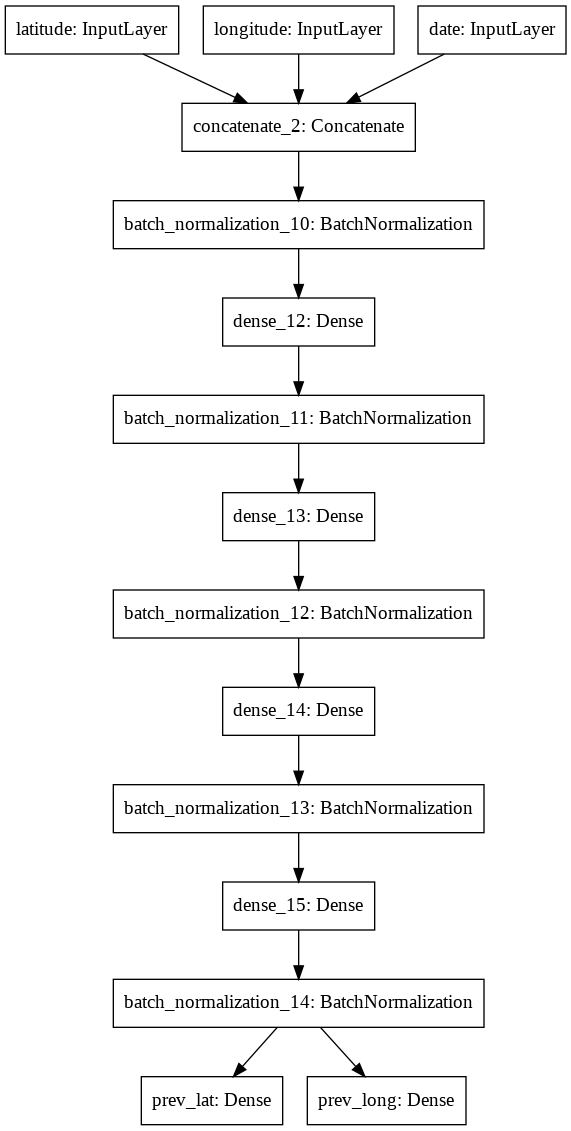

In [6]:
import tensorflow as tf
model = my_model()
tf.keras.utils.plot_model(model)

In [ ]:
initial_learning_rate = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 5000,
    decay_rate = 0.85,
    staircase = True)

model = my_model()
model.compile(loss = tf.keras.losses.MSE,
              optimizer = tf.keras.optimizers.Adam(lr_schedule))

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, mode = "min",
                                             restore_best_weights = True)

model.fit(x = [train_lat_x, train_lon_x, train_month_x],
          y = [train_lat_y, train_lon_y],
          validation_data = ([val_lat_x, val_lon_x, val_month_x], [val_lat_y, val_lon_y]),
          epochs = 20, callbacks = [earlystop])

In [ ]:
save = "./notlstm2.h5"
model.save(save)

from google.colab import files

files.download(save)

# Plot

In [ ]:
# i = 42627
# lat, lon, month = float(val_lat_x[i] * 90), float(val_lon_x[i] * 360), float(val_month_x[i] * 12)
lat = -23.96083 
lon = -46.33361 + 180
month = 09
test_lat = np.array([lat]) / 90
test_lon = np.array([lon]) / 360
test_month = np.array([month]) / 12
pred_lat = [lat / 90]
pred_lon = [lon / 360]

for i in range(10):
    prev_lat, prev_lon = model([np.expand_dims(test_lat, axis = 0), 
                                np.expand_dims(test_lon, axis = 0),
                                np.expand_dims(test_month, axis = 0)])
    
    prev_lat = prev_lat.numpy().squeeze()
    prev_lon = prev_lon.numpy().squeeze()

    pred_lat.append(prev_lat)
    pred_lon.append(prev_lon)

    test_lat = prev_lat
    test_lon = prev_lon

test_df = {"lat": np.array(pred_lat) * 90,
           "lon": np.array(pred_lon) * 360 - 180,
           "size": np.arange(10),
           "name": ["{}".format(month) for month in np.arange(10)]}

In [ ]:
fig = go.Figure(layout = dict(height = 600, width = 800))

fig.add_trace(go.Scattergeo(
    lat = test_df["lat"],
    lon = test_df["lon"],
    text = test_df["name"],
    mode = 'lines+markers+text',
    marker = dict(
        color = "rgb(0, 204, 150)",
        size = test_df["size"] + 20,
        cmin = 0,
        cmax= 16,
        )
    ))

fig.update_layout(
    geo = dict(
        lataxis = dict(
            range = [test_df["lat"].min() - 20, test_df["lat"].max() + 20],
            showgrid = True,
            dtick = 10
        ),
        lonaxis = dict(
            range = [test_df["lon"].min() - 40, test_df["lon"].max() + 40],
            showgrid = True,
            dtick = 20
        )
    )
)

fig.write_image("./fig1.png")
fig.show()